In [1]:
# Run this notebook after all the views have been processed using
# "continuous_run_dev2.ipynb".

# The first half of this notebook computes the rotation needed to rotate
# each of the views up right.
# The second half of this notebook computes an (inaccurate) upper bound 
# estimation of the volume of the crack using an extrusion method.
# Typically, the second half of the notebook is not run because the 
# upper bound is not very useful.

import cv2
from matplotlib import pyplot as plt
import numpy as np
import time, sys
from IPython.display import clear_output
from scipy import stats
import csv
import os
import pathlib
import pickle
import subprocess
from stl import mesh
import stl

# load custom modules
from image_proc_lib.file_util import *
from image_proc_lib.cv_util import *
from image_proc_lib.point_selector import *
from image_proc_lib.image_proc import *
from image_proc_lib.image_analyser2 import *

from geom_recon.utils import *
from geom_recon.view_manager import *
from geom_recon.plotting import *
from geom_recon.process_view_util import *
from geom_recon.scad_manager import *
from geom_recon.adjustment_cal import *

# just to shut up the stl library, otherwise, it prints too much...
import logging
logging.getLogger("stl").setLevel(logging.ERROR)
logging.getLogger(stl.__name__).setLevel(logging.ERROR) 

In [10]:
# define where to import and export data

# define the file names from which the frame by frame tracking data
# exported from "continuous_run_dev2.ipynb" can be loaded.
data_file_names = ['processed data 0/frame_descriptor_pickle_dump 0.pickle',\
                   'processed data 45/frame_descriptor_pickle_dump 45.pickle',\
                   'processed data 90/frame_descriptor_pickle_dump 90.pickle',\
                   'processed data 135/frame_descriptor_pickle_dump 135.pickle']

# define the export file names
export_dir = 'multi_view_data'
adj_export_file_name = export_dir + '\\adjustment.pickle'
vm_export_file_name = export_dir + "\\" + "vm_dump" + ".pickle"

# define th video frame inxed used in the calibration 
calib_frame = 700

# define the number of views and the position of the views.
n_view = 4
view_labels = ['0', '45', '90', '135']
view_angles = [0, 45, 90, 135]

In [11]:
# Load the frame by frame tracking data exported from "continuous_run_dev2.ipynb"
all_data = []
for i in range(n_view):
    curr_data = None
    with open(data_file_names[i], mode='rb') as f:
        curr_data = pickle.load(f)
    all_data.append(curr_data)

In [12]:
def retrieve_frame_descriptors(all_data, frame_of_interest):
    frame_descriptors = []
    for i in range(n_view):
        found = False
        for element in all_data[i]:
            if element.get_frame_ind_abs() == frame_of_interest:
                frame_descriptors.append(element)
                found = True
                break
        if not found:
            print("Error, frame " + str(frame_of_interest) + " for view " + str(i) + " not found!")
            break
    return frame_descriptors

In [13]:
# Some visualization just to make sure that in the calibration frame 
# selected, the detected contours are not affected by dust/other noise.
calib_frame_descriptors = retrieve_frame_descriptors(all_data, calib_frame)
plot_raw_hulls(calib_frame_descriptors, view_labels)

In [4]:
# Grab a frame from the frame from the experimental video to 
# calibrate for the rotation needed rotate each of the views up right.
vid_file_name = "P89.mxf"
vid_file_name_full = get_from_upper_dir(vid_file_name)
cap = VideoManager(vid_file_name_full)
first_frame = cap.retrieve_frame()

# The video time at which the frame is grabbed.
# The bead must already be in the tank at this time.
start_time = 25
start_frame = cap.load_to_time(start_time)
cap.close()

In [7]:
# Basic idea:
# 1. calculate the rotation needed
# 2. find a reference point (circle center)

# Each of the cell processes one view.
# There are a few steps needed:
# 1. Select the region occupied by the view from the full image
# 2. Select the points on the perimeter of the bead in the difference
#    image. This is used to compute the circle center, which is used as
#    the reference point for each of the views
# 3. Select a few points on one of the two vertical edges of the bead
#    holder, this is used to compute the rotation

# Note that the rotation and translation for each view is stored in
# the respective view manager ("vm") of the view.

In [14]:
p_0, vm_0 = process_view_init(first_frame, start_frame, calib_frame_descriptors[0], view_angles[0], view_labels[0], reduction_ratio=0.5)

select points on a vertical line
316.18651420661587


In [15]:
p_45, vm_45 = process_view_init(first_frame, start_frame, calib_frame_descriptors[1], view_angles[1], view_labels[1], reduction_ratio=0.3)

select points on a vertical line
319.29120208586386


select points on a vertical line
326.7339339908571


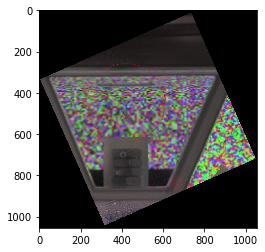

In [16]:
p_90, vm_90 = process_view_init(first_frame, start_frame, calib_frame_descriptors[2], view_angles[2], view_labels[2], True, reduction_ratio=0.3)

select points on a vertical line
322.431296807834


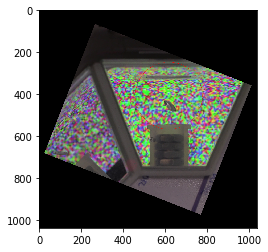

In [17]:
p_135, vm_135 = process_view_init(first_frame, start_frame, calib_frame_descriptors[3], view_angles[3], view_labels[3], True, reduction_ratio=0.3)

In [18]:
# compile the results
# the order MUST be correct!!!
p_list = [p_0, p_45, p_90, p_135]
vm_list = [vm_0, vm_45, vm_90, vm_135]

In [19]:
# make the export directory
if not exist_directory(export_dir):
    os.mkdir(export_dir)

# Obtain the adjustments
# The bead center coordinates might not be found very accurately using
# the circle fitting method. This may lead to some mis-alignment between
# the view.
# This segment of code computes the (small) translation needed in each view
# to align the views properly.
# If the (inaccurate) upper bound estimation of the volume of the crack using 
# the extrusion method is not needed, this segment can essentially be skipped by
# setting "ac.step_control" to a very large value.
scad_manager= ScadManager(p_0.bead_rad * 3)
ac = AdjustmentCalculator(scad_manager)
ac.step_control = 0.0002 # sets the tolerance of the adjustment
adj = ac.find_adjustment_all(p_list)
for i in range(1, n_view):
    scad_manager.render_highlight(p_list, adj, i+1, file_name=export_dir + '\\calib', label=str(calib_frame))
plot_processed_view(p_list, view_labels, adj)

Adjusting for element 1
iter: 0
curr_vol: 3.2255e+06
y change: -0.281%/pixel
additional_adjustment: [ 0 -1]
curr_adjustment: [ 0 -1]

iter: 1
curr_vol: 3.233e+06
y change: -0.233%/pixel
additional_adjustment: [ 0 -1]
curr_adjustment: [ 0 -2]

iter: 2
curr_vol: 3.2389e+06
y change: -0.18%/pixel
additional_adjustment: [ 0 -1]
curr_adjustment: [ 0 -3]

iter: 3
curr_vol: 3.2429e+06
y change: -0.125%/pixel
additional_adjustment: [ 0 -1]
curr_adjustment: [ 0 -4]

iter: 4
curr_vol: 3.2449e+06
y change: -0.0626%/pixel
additional_adjustment: [ 0 -1]
curr_adjustment: [ 0 -5]

iter: 5
curr_vol: 3.2447e+06
y change: 0.0089%/pixel
additional_adjustment: [0 0]
curr_adjustment: [ 0 -5]

adjustmnet ended
-------------------------------------------------------------------------
current_adjustment: [[0.0, 0.0], [0.0, -5.0], [0.0, 0.0], [0.0, 0.0]]

Adjusting for element 2
iter: 0
curr_vol: 8.976e+05
x change: 0.0679%/pixel
y change: 0.408%/pixel
additional_adjustment: [1 1]
curr_adjustment: [1 1]

iter:

In [20]:
# a visualization to show the positions of the contours of the cracks
# in the four views after they have been rotated upright and aligned.
plot_processed_view(p_list, view_labels)

In [21]:
# export the view managers
f = open_file_w_with_check(vm_export_file_name, mode='wb')
if not (f is None):
    pickle.dump(vm_list, f)
    f.close()

# export the adjustment information
f = open_file_w_with_check(adj_export_file_name, mode='wb')
if not (f is None):
    pickle.dump(adj, f)
    f.close()

In [ ]:
# The cells below are for the extrusion method which provides 
# an (inaccurate) upper bound estimate of the crack volume.
# The cells below are typically not used.

In [18]:
# run this is the view manager is loaded rather than created
vm_list = []
with open(vm_export_file_name, mode='rb') as f:
    vm_list = pickle.load(f)
adj = None
with open(adj_export_file_name, mode='rb') as f:
    adj = pickle.load(f)

In [16]:
def process_view(descriptor, vm):
    descriptor_hull = descriptor.get_convex_hull_rel()[:, 0]
    # print(descriptor_hull)
    descriptor_roi = descriptor.get_roi()
    cnt = vm.transform_contour(descriptor_hull, descriptor_roi, ret_img_coord=False)
    processed_descriptor = ProcessedDescriptor(descriptor)
    processed_descriptor.bead_rad = vm.bead_rad
    processed_descriptor.processed_cnt = cnt
    processed_descriptor.angle = vm.angle
    processed_descriptor.label = vm.label
    return processed_descriptor

In [17]:
def process_frame(frame_ind, vm_list, adj_list, scad_manager):
    raw_descriptors = retrieve_frame_descriptors(all_data, frame_ind)
    p_list = []
    for i in range(n_view):
        p_list.append(process_view(raw_descriptors[i], vm_list[i]))
    
    # now, export the data
    sub_dir = export_dir + '\\frame' + str(frame_ind)
    if not exist_directory(sub_dir):
        os.mkdir(sub_dir)
    
    # export the "cumulative view"
    for i in range(1, n_view):
        scad_manager.render_highlight(p_list, adj, i+1, file_name=sub_dir + '\\processed', label=str(frame_ind))
    return scad_manager.export_geom(p_list, adj, sub_dir + '\\processed')

In [18]:
frames = [i for i in range(550, 800, 20)]
#[1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800]
vol = []
for ind in frames:
    print('ind: ' + str(ind) + '         ', end='\r')
    vol.append(process_frame(ind, vm_list, adj, scad_manager))

In [21]:
frames = [i for i in range(460, 980, 20)]

In [22]:
plt.plot(frames[0:-8], vol[0:-8])
plt.xlabel('frame index')
plt.ylabel('V/pixels^2')
plt.title("V against time")
plt.show()

In [23]:
max_len_list = []
for ind in frames:
    descriptors = retrieve_frame_descriptors(all_data, ind)
    temp_list = [descriptors[i].max_len for i in range(n_view)]
    max_len_list.append(temp_list)
max_len_list = np.array(max_len_list)

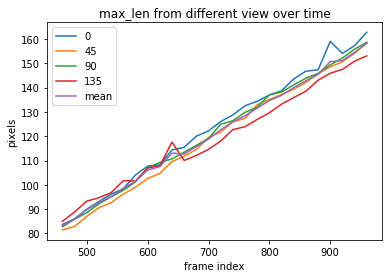

In [24]:
# compare the max_len
for i in range(n_view):
    plt.plot(frames, max_len_list[:,i])
mean_list = [np.mean(ele) for ele in max_len_list]
plt.plot(frames, mean_list)
plt.legend(view_labels + ['mean'])
plt.xlabel('frame index')
plt.ylabel('pixels')
plt.title('max_len from different view over time')
plt.show()

In [25]:
# need to remove some if it because towards the end,
# 90 deg view detected some bubbles, and this messes up the hull
log_r = np.log(mean_list[0:-8])
log_vol = np.log(vol[0:-8])
slope, intercept, r_value, p_value, std_err = stats.linregress(log_r, log_vol)
estimated_y = log_r*slope + intercept
plt.scatter(log_r, log_vol)
plt.plot(log_r, estimated_y)
ax = plt.gca()
plt.text(0.95, 0.05, 
         "equation: log(V) = " + f'{slope:.3}' + \
         ' log(D) + ' + f'{intercept:.3}' + \
         '\nerr = ' + f'{std_err:.3}',
         fontsize=12,
         horizontalalignment='right', 
         verticalalignment='bottom', 
         transform=ax.transAxes)
plt.title("log-log plot for V against D")
plt.xlabel("log(D)")
plt.ylabel("log(V)")

Text(0, 0.5, 'log(V)')